In [9]:
import re
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import ROOT
from tqdm import tqdm
from scipy.interpolate import interp1d
from matplotlib import colors


mpl.rcParams.update({
    'text.usetex':     False,
    'mathtext.fontset':'cm',                
    'font.family':     'serif',
    'font.serif':      ['DejaVu Serif'],    
    'font.size':       12,
    'axes.labelsize':  14,
})

In [10]:
# Going from horizontal to equatorial coordinates
def horiz_to_equatorial(az_deg, alt_deg, lat_rad, lst_rad):
    az  = np.radians(az_deg)
    alt = np.radians(alt_deg)
    # declination
    sin_dec = np.sin(alt)*np.sin(lat_rad) + np.cos(alt)*np.cos(lat_rad)*np.cos(az)
    dec     = np.arcsin(sin_dec)
    # hour angle
    sin_ha = -np.sin(az)*np.cos(alt)/np.cos(dec)
    cos_ha = (np.sin(alt) - np.sin(lat_rad)*sin_dec)/(np.cos(lat_rad)*np.cos(dec))
    ha     = np.arctan2(sin_ha, cos_ha)
    # RA = LST − HA, mod 2π maps to [0,2π)
    ra = (lst_rad - ha) % (2*np.pi)
    return ra, dec

In [11]:
# THIS CELL AND THE NEXT ONE ARE FOR THE 360 deg FOV CONFIGURATION
# This code reads the txt file generated by the Trinity Performance Code. 
# Note that this only works for the 360FoV Configuration because of how the txt file is generated
input_filename = 'files/out_140525_1932.txt'      
output_folder   = 'skymaps_360FoV'
latitude_deg    = 38.52028                     # degrees
lst_hours       = 12                     # local sidereal time (hours)

os.makedirs(output_folder, exist_ok=True)

# Converting to radians
lat_rad = np.radians(latitude_deg)
lst_rad = np.radians(lst_hours * 15.0)       # hours → degrees → radians

# Compiled regular expression
energy_pat = re.compile(r'Running .* from ([0-9.]+) to ([0-9.]+)log10')
data_pat   = re.compile(
    r'Y:\s*([\d.]+),\s*Elevation:\s*([\d.]+),\s*Azimuth:\s*([\d.]+),\s*dDeltaAcceptance:\s*([\d.eE+-]+)'
)

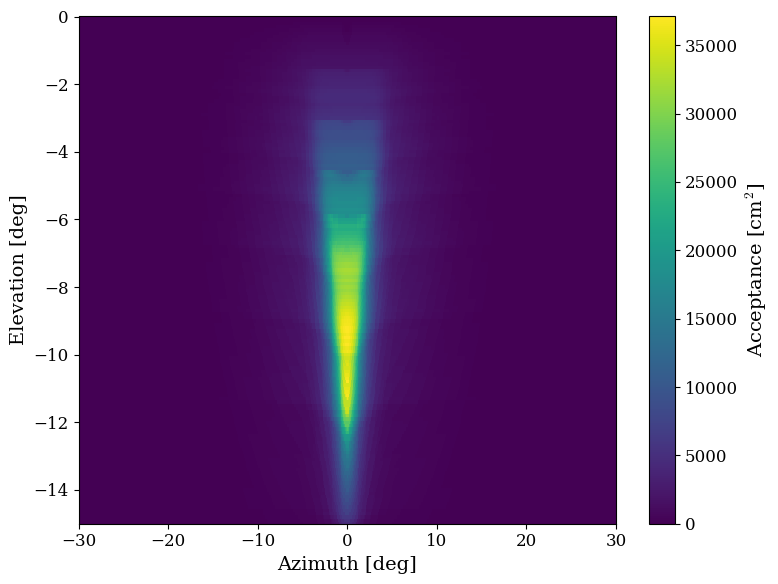

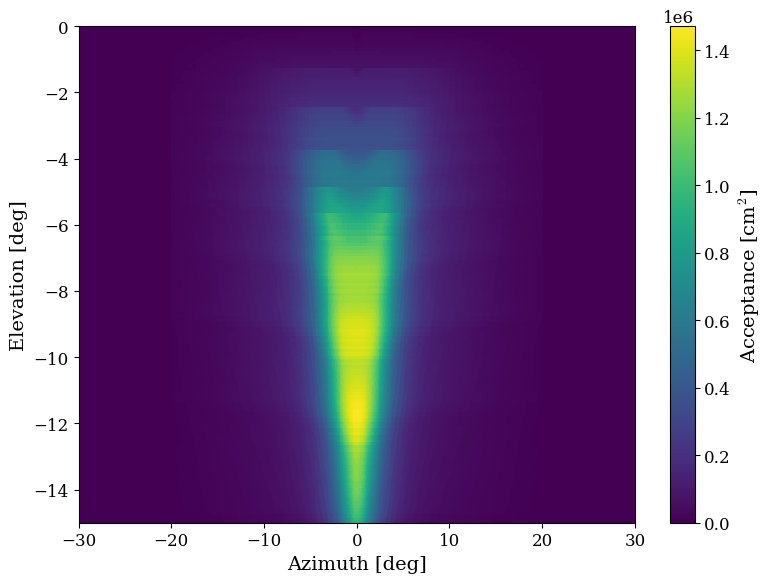

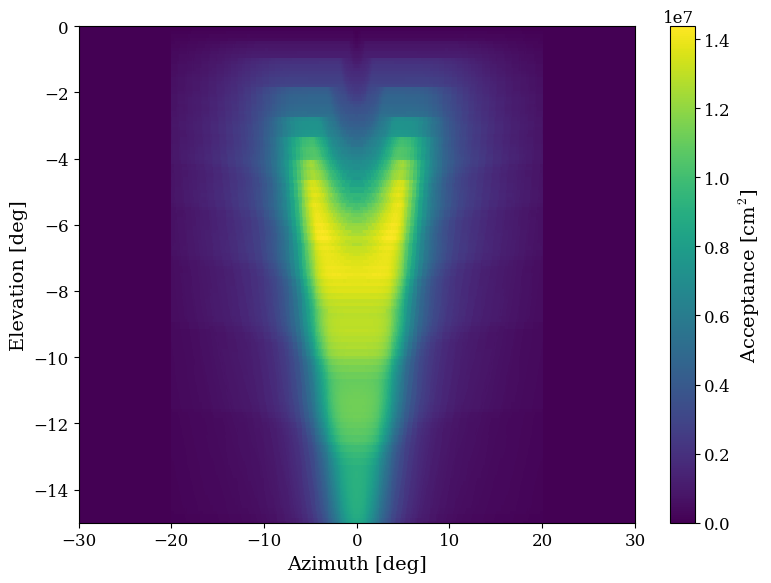

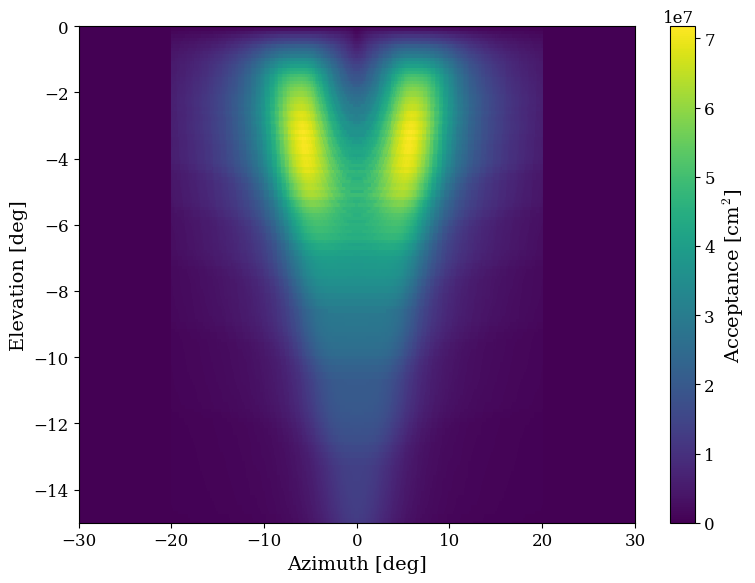

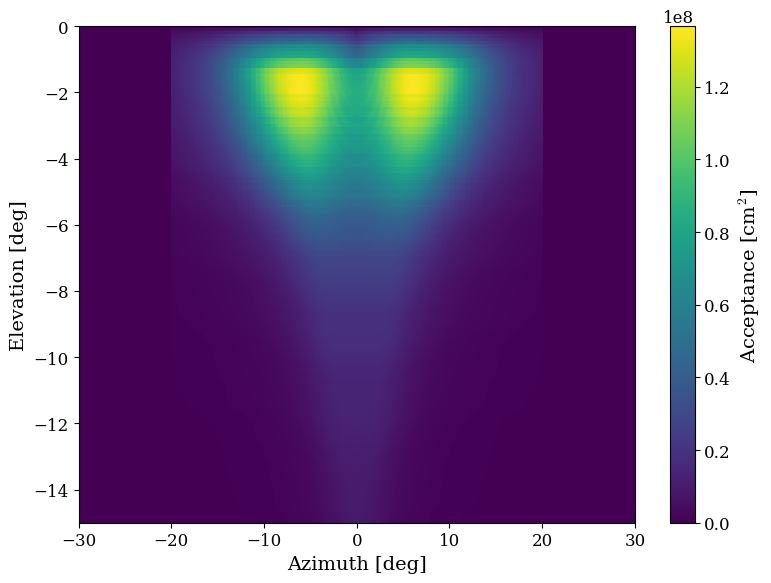

In [12]:
energies = [5,6,7,8,9] #log10(Emin) [GeV]

for i in energies:
    f = ROOT.TFile.Open(f"files/PointSourceAcceptance_FoV360deg_Index2.0_Emin{i}.5_Emax{i+1}.5.root")

    # get TH2 histogram
    h2 = f.Get("skyAcceptance")
    if not h2:
        raise ValueError("Could not find a histogram named 'skyAcceptance' in the file.")
    
    # Get binning info
    nx = h2.GetNbinsX()
    ny = h2.GetNbinsY()
    
    # pull out just the bin contents into a (nx×ny) NumPy array
    acceptance = np.zeros((nx, ny))
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            acceptance[i-1, j-1] = h2.GetBinContent(i, j)
    
    # Also get the bin‐center coordinates
    x_centers = np.array([h2.GetXaxis().GetBinCenter(i) for i in range(1, nx+1)])
    y_centers = np.array([h2.GetYaxis().GetBinCenter(j) for j in range(1, ny+1)]) 

    # now plot
    plt.figure(figsize=(8,6))
    mesh = plt.pcolormesh(
        x_centers,     # x bin edges
        y_centers,     # y bin edges
        acceptance.T,      # transpose so that data[:,j] aligns with y
        shading='auto'
    )
    plt.xlabel("Azimuth [deg]")
    plt.ylabel("Elevation [deg]")
    cbar = plt.colorbar(mesh)
    cbar.set_label("Acceptance [cm$^2$]")
    plt.xlim([-30,30])
    plt.ylim([-15,0])
    plt.tight_layout()
    plt.show()

In [15]:
# raw_points = list of (energy_midpoint, elevation, azimuth, acceptance)
raw_points = []
current_E = None

with open(input_filename) as f:
    for line in f:
        m = energy_pat.search(line)
        if m:
            # midpoint of that energy bin
            current_E = (float(m.group(1)) + float(m.group(2))) / 2.0
            continue
        m2 = data_pat.search(line)
        if m2 and current_E is not None:
            _, elev, az, acc = map(float, m2.groups())
            raw_points.append((current_E, elev, az, acc))


# BUILD AND PLOT
# group raw_points by energy
energies = sorted({p[0] for p in raw_points})

# arrays to store stuff
azimuth = []
elevation = []
effective_area = []

for E in tqdm(energies):
    # select all points for this energy
    sel = [(elev, az, acc) for (Emid, elev, az, acc) in raw_points if Emid == E]
    elevs = np.array([p[0] for p in sel])
    azs   = np.array([p[1] for p in sel])
    accs  = np.array([p[2] for p in sel])

    # sum over az & Y for each elevation
    unique_elevs = np.unique(elevs)
    summed_acc  = {e: accs[elevs==e].sum() for e in unique_elevs}

    # recover original azimuth step
    az_steps = np.unique(np.diff(np.sort(np.unique(azs))))
    az_step  = float(az_steps.min()) if az_steps.size>0 else 1.0
    az_full  = np.arange(0, 360, az_step)

    # build full grid with constant acceptance per elevation
    elev_full = np.repeat(unique_elevs, az_full.size)
    az_full   = np.tile(az_full, unique_elevs.size)
    # Acceptance is multiplied by 2 because the file only goes from 0-20 deg in azimuth (maximum Cherenkov angle) and should go from [-20,20]
    acc_full  = 2*np.concatenate([np.full(az_full.size//len(unique_elevs), summed_acc[e]) 
                                for e in unique_elevs])
    # restrict azimuth to 30°–330°
    mask = (az_full >= 60) & (az_full <= 300)
    az_full   = az_full[mask]
    elev_full = elev_full[mask]
    acc_full  = acc_full[mask]

    azimuth.append(az_full)
    elevation.append(elev_full)
    effective_area.append(acc_full) 
   
    # convert to RA/Dec
    ras, decs = horiz_to_equatorial(az_full, -1*elev_full, lat_rad, lst_rad)

    # map RA→ longitude for Mollweide (lon∈[−π,π])
    lon = np.pi - ras
    lon = (lon + np.pi) % (2*np.pi) - np.pi

    # plot
    fig = plt.figure(figsize=(8,4.5))
    ax  = fig.add_subplot(1,1,1, projection='mollweide')
    sc  = ax.scatter(lon, decs, c=acc_full, s=4, cmap='inferno')
    cb  = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
    cb.set_label(r'$\rm{Effective \: Area} [\rm{cm}^2]$')
    ax.set_title(fr'$E_\nu ≃ 10^{{{E:.1f}}} [\rm{{GeV}}]$')
    ax.grid(True)

    out_name = f'skymap_azimuth_rotation_E{E:.1f}.png'
    fig.savefig(os.path.join(output_folder, out_name), dpi=150)
    plt.close(fig)
    np.savez_compressed(f'acceptance_instantaneous_{E:.1f}',
        lon=lon,
        decs=decs,
        events=acc_full
    )
    
print("Done! Skymaps are in", output_folder)


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.44s/it]

Done! Skymaps are in skymaps_360FoV


In [16]:
latitude_deg = 38.5217                       # degrees
lst_hours    = 12.00                         # local sidereal time (hours)
lat_rad      = np.radians(latitude_deg)
lst0_rad     = np.radians(lst_hours * 15.0)  # convert H→°

# —————————————————————————————
# 2) Time grid (8 h total, sampled at n_steps)
t_total   = 8 * 3600      # total integration time in seconds
n_steps   = 200           # number of LST snapshots
times     = np.linspace(0, t_total, n_steps)
dt = times[1] - times[0]
omega_sid = 2 * np.pi / 86164.0905  # sidereal rate [rad/s]

n_ra_bins  = 6400
n_dec_bins = 3200

n_pix = n_ra_bins * n_dec_bins

lon_avg      = []
dec_avg      = []
acc_avg_flat = []
acc_alone    = []
# —————————————————————————————
total_iters = len(azimuth) * len(times)
pbar = tqdm(total=total_iters, desc="Processing")

ra_bins  = np.linspace(-np.pi,   np.pi,   n_ra_bins+1)
dec_bins = np.linspace(-np.pi/2, np.pi/2, n_dec_bins+1)

ra_centers  = 0.5 * (ra_bins[:-1]  + ra_bins[1:])
dec_centers = 0.5 * (dec_bins[:-1] + dec_bins[1:])
ra_grid, dec_grid = np.meshgrid(ra_centers, dec_centers, indexing='ij')

for i in range(len(azimuth)):
    az_flat = azimuth[i]
    el_flat = -1*elevation[i]

    
    # two accumulators:
    H_acc = np.zeros((n_ra_bins, n_dec_bins))  # sum of acceptance
    H_cnt = np.zeros_like(H_acc)               # number of hits
    
    for t in times:
        
        lst_rad = lst0_rad + omega_sid * t
        # turn (az,el)→(RA,Dec)
        ras, decs = horiz_to_equatorial(az_flat, el_flat, lat_rad, lst_rad)
        # adjust to Mollweide’s convention:
        lon_eq = np.pi - ras
        lon_eq = (lon_eq + np.pi) % (2*np.pi) - np.pi
    
        # 5a) accumulate acceptance
        H_step_acc, _, _ = np.histogram2d(
            lon_eq,
            decs,
            bins=[ra_bins, dec_bins],
            weights=effective_area[i]*dt
        )
        H_acc += H_step_acc
    
        # 5b) accumulate a simple count of contributions
        H_step_cnt, _, _ = np.histogram2d(
            lon_eq,
            decs,
            bins=[ra_bins, dec_bins],
            weights=np.ones_like(effective_area[i]*dt)
        )
        H_cnt += (H_step_cnt > 0).astype(float)
        pbar.update(1)
    
    
    H_avg = H_acc/t_total
    
    # —————————————————————————————
 
    lon_avg.append(ra_grid.ravel())
    dec_avg.append(dec_grid.ravel())
    acc_avg_flat.append(H_avg.ravel())
    acc_alone.append(H_acc.ravel())
    



Processing: 0it [07:07, ?it/s]                                                                 | 0/1000 [00:00<?, ?it/s]

Processing: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [04:49<00:00,  3.86it/s]

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

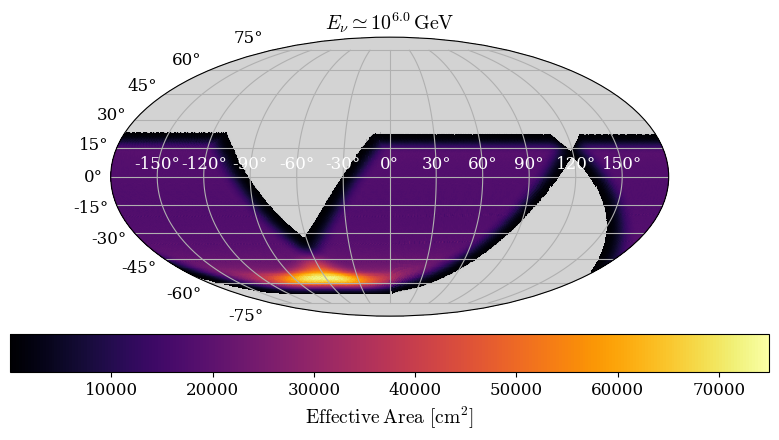

 20%|█████████████████                                                                    | 1/5 [00:03<00:15,  3.79s/it]

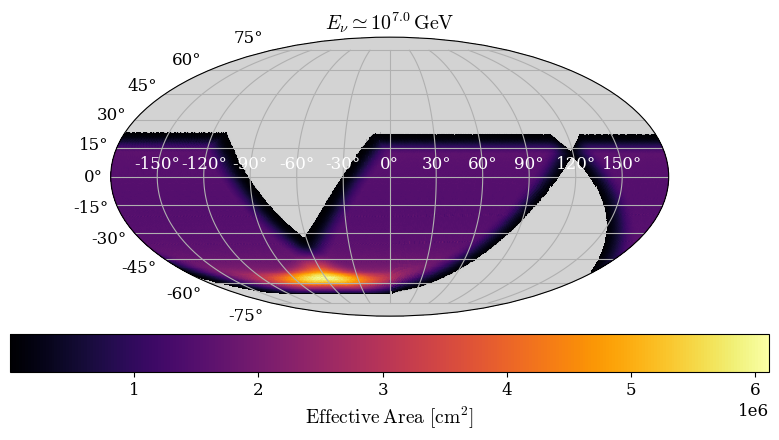

 40%|██████████████████████████████████                                                   | 2/5 [00:07<00:10,  3.54s/it]

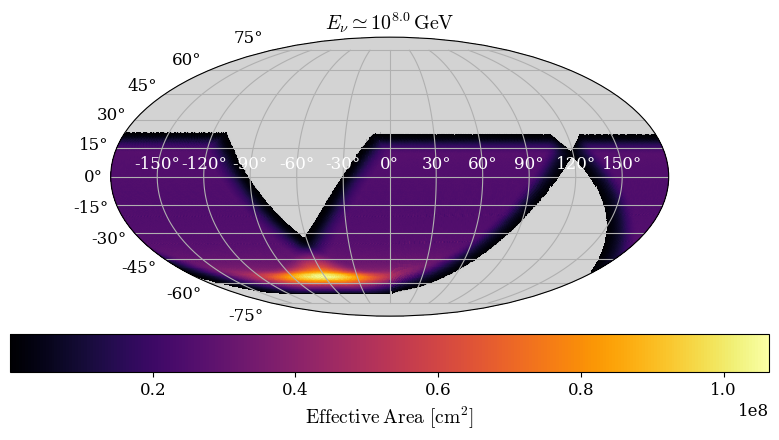

 60%|███████████████████████████████████████████████████                                  | 3/5 [00:11<00:07,  3.75s/it]

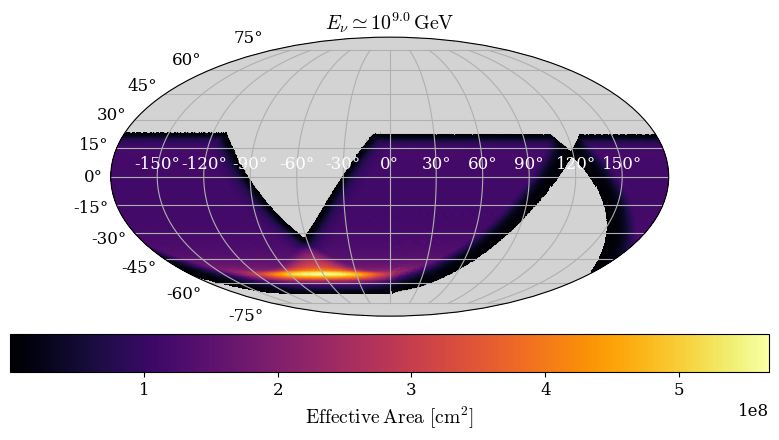

 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:14<00:03,  3.73s/it]

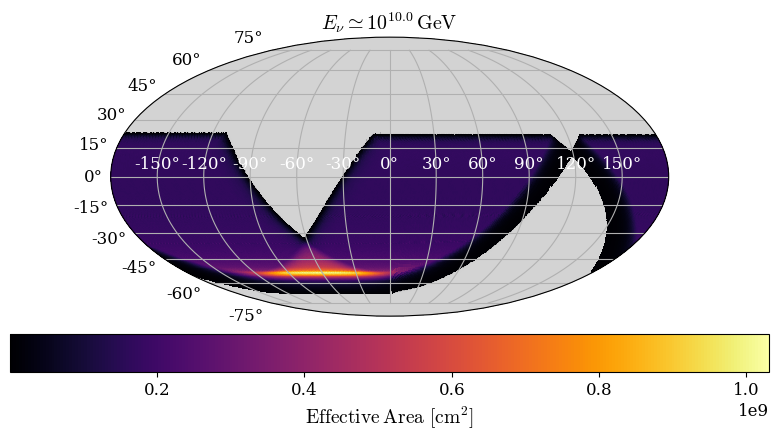

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.82s/it]

Done! Skymaps are in skymaps_daily_average
CPU times: user 18.9 s, sys: 261 ms, total: 19.2 s
Wall time: 19.1 s


In [18]:
%%time 
output_folder   = 'skymaps_daily_average'

os.makedirs(output_folder, exist_ok=True)

lon_ds_reduced = []
dec_ds_reduced = []
H_ds_reduced = []

for i in tqdm(range(len(acc_avg_flat))):
    # Rebuild 2D arrays from your existing flat arrays
    # (these shapes match how you raveled them with indexing='ij')
    assert lon_avg[i].size == n_ra_bins * n_dec_bins
    assert dec_avg[i].size == n_ra_bins * n_dec_bins
    assert acc_avg_flat[i].size == n_ra_bins * n_dec_bins
    
    lon2d = lon_avg[i].reshape(n_ra_bins, n_dec_bins)       # RA (x) by Dec (y)
    dec2d = dec_avg[i].reshape(n_ra_bins, n_dec_bins)
    H2    = acc_avg_flat[i].reshape(n_ra_bins, n_dec_bins)   # values on the grid
    
    # choose plotting resolution (degrees) – only affects the plot
    reso_deg = 0.3  # try 2.0 or 5.0 for faster
    
    ra_step_deg  = 360.0 / n_ra_bins
    dec_step_deg = 180.0 / n_dec_bins
    fx = max(1, int(np.floor(reso_deg / ra_step_deg)))
    fy = max(1, int(np.floor(reso_deg / dec_step_deg)))
    
    # crop so reshape/slicing divides evenly
    n_ra_c  = (n_ra_bins // fx) * fx
    n_dec_c = (n_dec_bins // fy) * fy
    
    lon_c = lon2d[:n_ra_c, :n_dec_c]
    dec_c = dec2d[:n_ra_c, :n_dec_c]
    H_c   = H2   [:n_ra_c, :n_dec_c]
    
    # block-reduce values (mean/sum/max as you prefer)
    H_ds = H_c.reshape(n_ra_c//fx, fx, n_dec_c//fy, fy).mean(axis=(1,3))
    lon_ds = lon_c[::fx, ::fy]   # representative centers per block
    dec_ds = dec_c[::fx, ::fy]
    
    '''
    fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(8, 4.5))
    sc = ax.scatter(
        lon_ds.ravel(), dec_ds.ravel(),
        c=H_ds.ravel(),
        s=4, marker=",", linewidths=0, antialiased=False,
        cmap='inferno', rasterized=True
    )
    cb = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
    cb.set_label(r'$\mathrm{Effective\ Area}\ [\mathrm{cm}^2]$')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    '''
    # Set up log color scaling using the *downsampled* values
    pos = H_ds[H_ds > 0]
    if pos.size == 0:
        raise ValueError("All values are non-positive; log color scale can't be used.")
    
    vmin = float(pos.min())
    vmax = float(H_ds.max())
    
    # Use an "under" color for zeros (and any ≤0 values)
    H_plot = H_ds.copy()
    H_plot[H_plot <= 0] = vmin * 0.5  # ensures they go below vmin for 'under' color

    # Append lists for later calculations
    lon_ds_reduced.append(lon_ds)
    dec_ds_reduced.append(dec_ds)
    H_ds_reduced.append(H_ds)
    
    cmap = plt.get_cmap('inferno').copy()
    cmap.set_under('lightgray', alpha=0.8)

    # Plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(8, 4.5))
    sc = ax.scatter(
        lon_ds.ravel(), dec_ds.ravel(),
        c=H_plot.ravel()/3,
        s=4, marker=",", linewidths=0, antialiased=False,
        cmap=cmap,
        vmin=vmin/3, vmax=vmax/3,   # linear scale use colors.LogNorm for logarithmic scale
        rasterized=True
    )
    cb = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
    cb.set_label(r'$\rm{Effective \: Area}\ [\rm{cm}^2]$')
    ax.grid(True)
    ax.tick_params(axis='x', colors='white')
    ax.set_title(fr'$E_\nu \simeq 10^{{{energies[i]:.1f}}}\,\mathrm{{GeV}}$')
    plt.tight_layout()
    out_name = f'daily_E_{energies[i]:.1f}_GeV.jpg'
    fig.savefig(os.path.join(output_folder, out_name), dpi=150)
    plt.show()  

print("Done! Skymaps are in", output_folder)


%|                                                                                             | 0/5 [00:00<?, ?it/s]

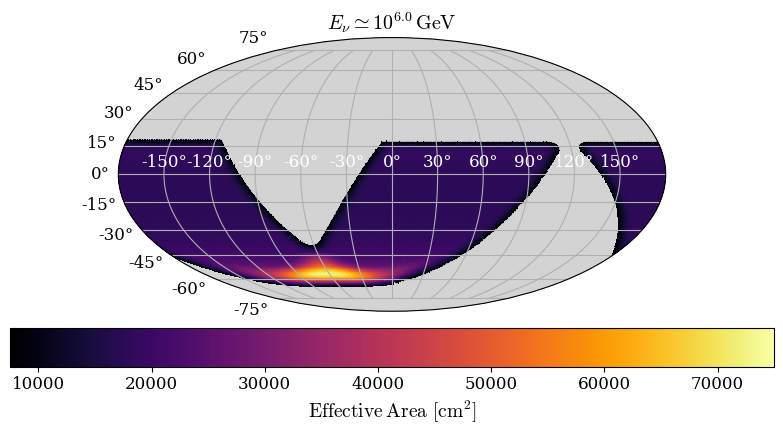


%|█████████████████                                                                    | 1/5 [00:08<00:35,  8.94s/it]

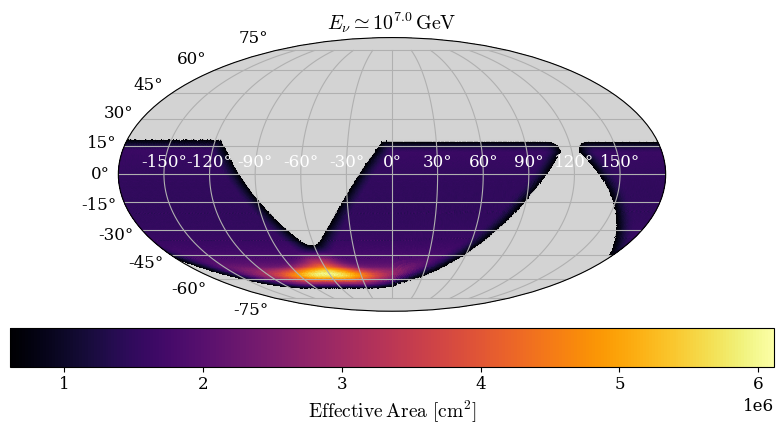


%|██████████████████████████████████                                                   | 2/5 [00:14<00:21,  7.05s/it]

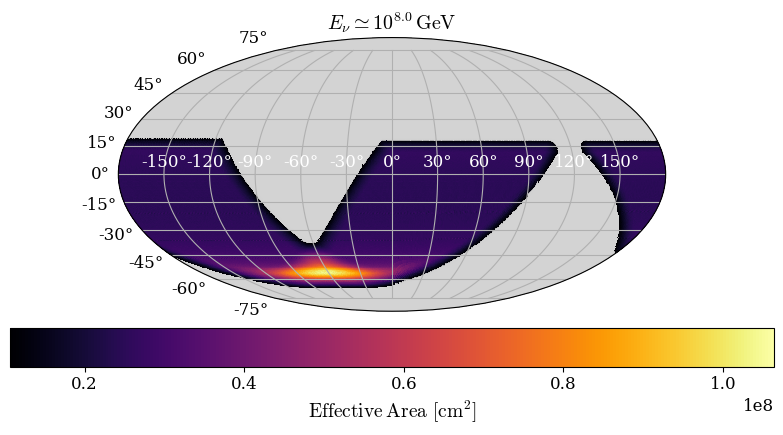


%|███████████████████████████████████████████████████                                  | 3/5 [00:20<00:12,  6.39s/it]

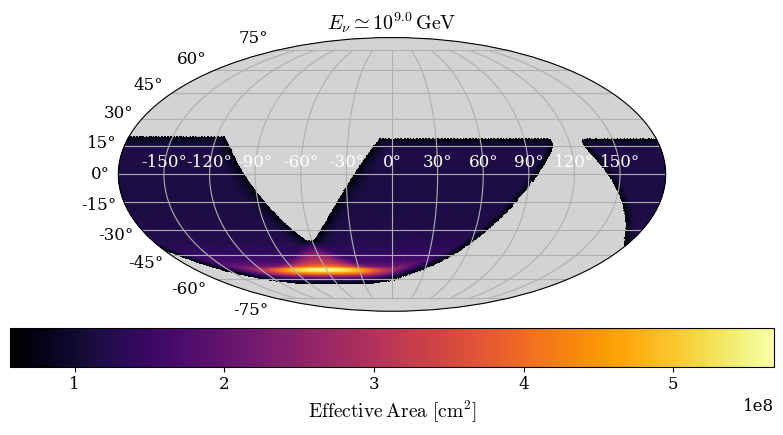


%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:25<00:06,  6.08s/it]

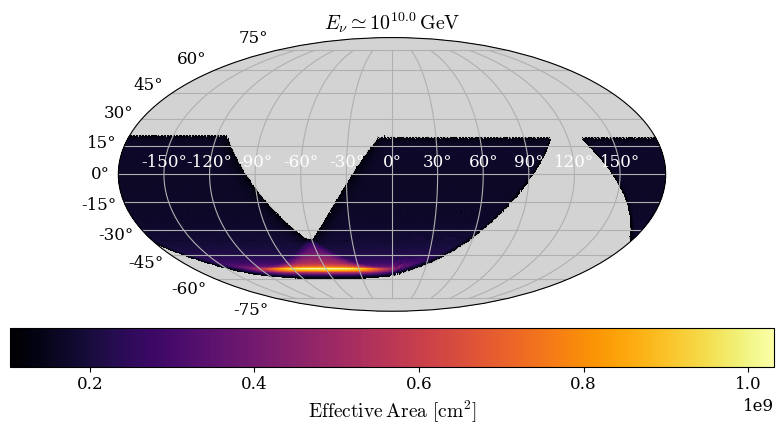


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.29s/it]


In [126]:
output_folder   = 'skymaps_daily_average_reduced'

os.makedirs(output_folder, exist_ok=True)

for i in tqdm(range(len(H_ds_reduced))):
    Hmax  = float(H_ds_reduced[i].max())
    vmin  = 0.1 * Hmax   # 10% threshold
    vmax  = Hmax
    
    # Clip values below threshold so they use the "under" color
    H_plot = H_ds_reduced[i].copy()
    H_plot[H_plot < vmin] = vmin * 0.9  # ensures they plot below vmin
    
    cmap = plt.get_cmap('inferno').copy()
    cmap.set_under('lightgray', alpha=0.8)
    
    # -------------------------------
    # Plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(8, 4.5))
    sc = ax.scatter(
        lon_ds_reduced[i].ravel(), dec_ds_reduced[i].ravel(),
        c=H_plot.ravel()/3,
        s=4, marker=",", linewidths=0, antialiased=False,
        cmap=cmap,vmin=vmin/3, vmax=vmax/3,
        rasterized=True
    )
    cb = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
    cb.set_label(r'$\rm{Effective \: Area}\ [\rm{cm}^2]$')
    ax.grid(True)
    ax.tick_params(axis='x', colors='white')
    ax.set_title(fr'$E_\nu \simeq 10^{{{energies[i]:.1f}}}\,\mathrm{{GeV}}$')
    plt.tight_layout()
    out_name = f'daily_reduced_E_{energies[i]:.1f}_GeV.jpg'
    fig.savefig(os.path.join(output_folder, out_name), dpi=150)
    plt.tight_layout()
    plt.show()

# Daily Skymaps

In [8]:
max_eff_area = np.array([max(acc_avg_flat[0]),max(acc_avg_flat[1]),max(acc_avg_flat[2]),max(acc_avg_flat[3]),max(acc_avg_flat[4])])
energies = np.array([1e6,1e7,1e8,1e9,1e10])

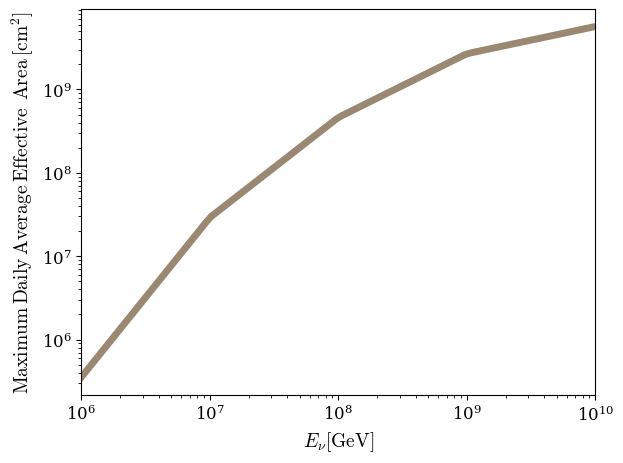

In [9]:
int_max_eff_area_60 = interp1d(np.log10(energies*1e9),np.log10(max_eff_area),fill_value="extrapolate")
energy = np.logspace(np.log10(energies[0]*1e9),np.log10(energies[-1]*1e9),100) #eV

def neutrino_fluence_sensitivity(E):
    ratio = E/(10**int_max_eff_area_60(np.log10(E)))
    return 3*2.44/np.log(10)*ratio

plt.loglog(energy*1e-9,10**int_max_eff_area_60(np.log10(energy)), label = 'hFoV = 60', color = '#9A8873', lw ='5')
plt.xlabel(r'$E_\nu \rm{[GeV]}$')
plt.ylabel(r'$\rm{Maximum\: Daily\:Average\: Effective\:\:Area}\:[\rm{cm}^2]$')
plt.xlim([1e6,1e10])
plt.tight_layout()
plt.show()

In [10]:
neutrino_fluence_60_max = [1e-9*neutrino_fluence_sensitivity(i)*3 for i in energy] # GeV cm^-2

In [11]:
# Thresholds at 10% of the maxima
thresholds = 0.1 * max_eff_area

acc_kept =  []
for i in range(len(acc_avg_flat)):
    acc = np.asarray(acc_avg_flat[i])

    thr = thresholds[i]
    mask = acc >= thr

    acc_kept.append(acc[mask])

# Convert to numpy object arrays if needed
masked_acc = np.array(acc_kept, dtype=object)


In [12]:
min_eff_area = np.array([np.nanmin(masked_acc[0]),np.nanmin(masked_acc[1]),np.nanmin(masked_acc[2]),np.nanmin(masked_acc[3]),np.nanmin(masked_acc[4])])

In [13]:
min_eff_area

array([3.55764417e+04, 2.91423050e+06, 4.62046630e+07, 2.68389178e+08,
       5.68520354e+08])

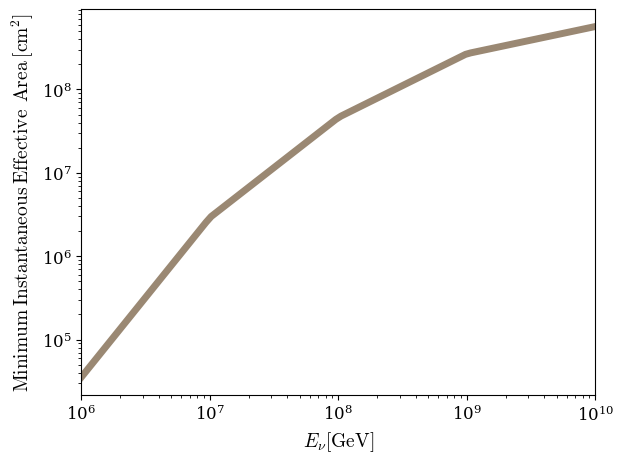

In [16]:
int_min_eff_area_60 = interp1d(np.log10(energies*1e9),np.log10(min_eff_area),fill_value="extrapolate")
energy = np.logspace(np.log10(energies[0]*1e9),np.log10(energies[-1]*1e9),100) #eV

def neutrino_fluence_sensitivity(E):
    ratio = E/(10**int_min_eff_area_60(np.log10(E)))
    return 3*2.44/np.log(10)*ratio

plt.loglog(energy*1e-9,10**int_min_eff_area_60(np.log10(energy)), label = 'hFoV = 60', color = '#9A8873', lw ='5')
plt.xlabel(r'$E_\nu \rm{[GeV]}$')
plt.ylabel(r'$\rm{Minimum\: Instantaneous\: Effective\:\:Area}\:[\rm{cm}^2]$')
plt.xlim([1e6,1e10])
plt.tight_layout()
plt.show()

In [17]:
neutrino_fluence_60_min = [1e-9*neutrino_fluence_sensitivity(i)*3 for i in energy] # GeV cm^-2

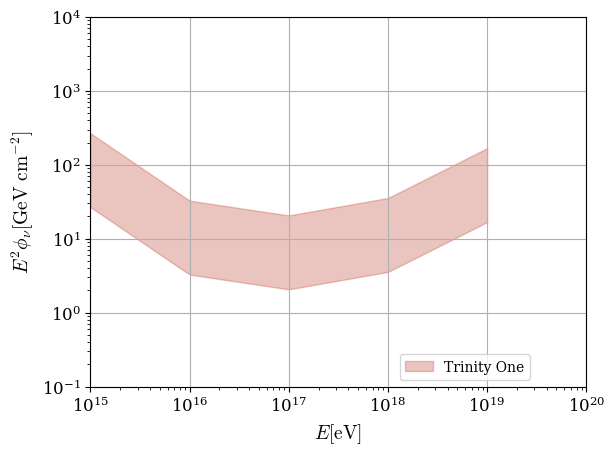

In [19]:
plt.fill_between(
    energy,
    neutrino_fluence_60_min,
    neutrino_fluence_60_max,
    color='#BC412B',
    alpha=0.3,
    label='Trinity One'
)

plt.ylabel(r'$E^2 \phi_\nu [\rm{GeV\ cm}^{-2}]$')
plt.xlabel(r'$E [\rm{eV}]$')
plt.grid()
plt.ylim([1e-1, 1e4])
plt.xlim([1e15, 1e20])
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right', frameon=True, bbox_to_anchor=(0.9, 0), fontsize='small')
plt.savefig('sensitivity.jpeg', dpi=150)

In [39]:
# Other experiment stuff
beacon_min = np.genfromtxt('files/BEACON_1000_min.csv', delimiter = ',')
beacon_max = np.genfromtxt('files/BEACON_1000_max.csv', delimiter = ',')

x_beacon_min, y_beacon_min = beacon_min[:,0], beacon_min[:,1]
x_beacon_max, y_beacon_max = beacon_max[:,0], beacon_max[:,1]

x_beacon = np.union1d(x_beacon_min, x_beacon_max)
logymin_i = np.interp(np.log10(x_beacon), np.log10(x_beacon_min), np.log10(y_beacon_min))
logymax_i = np.interp(np.log10(x_beacon), np.log10(x_beacon_max), np.log10(y_beacon_max))
y_beacon_min_i = 10**logymin_i
y_beacon_max_i = 10**logymax_i

In [59]:
#Models

magnetars_2 = np.genfromtxt('files/Magnetar_2.csv', delimiter = ',')
magnetars_1 = np.genfromtxt('files/Magnetar_1.csv', delimiter = ',')
fsrqs = np.genfromtxt('files/FSRQs.csv', delimiter = ',')

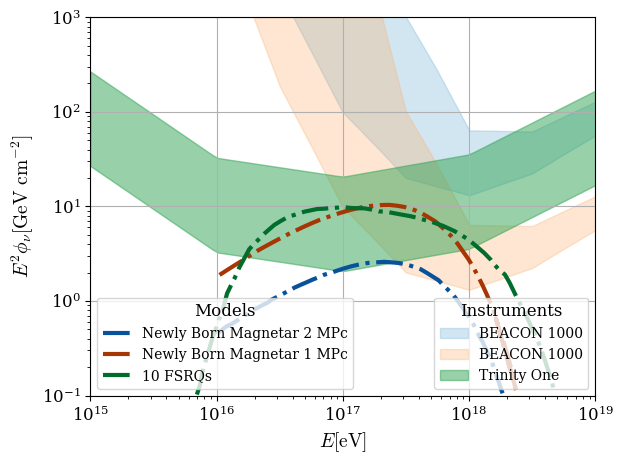

In [93]:
plt.fill_between(x_beacon, 10*y_beacon_min_i, 10*y_beacon_max_i, alpha=0.3, label='BEACON 1000', color = '#6baed6')
plt.fill_between(x_beacon, y_beacon_min_i, y_beacon_max_i, alpha=0.3, label='BEACON 1000', color = '#fdae6b')
plt.fill_between(
    energy,
    neutrino_fluence_60_min,
    neutrino_fluence_60_max,
    color='#31a354',
    alpha=0.5,
    label='Trinity One'
)
plt.plot(magnetars_2[:,0],magnetars_2[:,1], lw = 3, color = '#08519c', ls = '-.', label = 'Newly Born Magnetar 2 MPc')
plt.plot(magnetars_1[:,0],magnetars_1[:,1], lw = 3, color = '#a63603', ls = '-.', label = 'Newly Born Magnetar 1 MPc')
plt.plot(fsrqs[:,0]*1e9,fsrqs[:,1], lw = 3, color = '#006d2c', ls = '-.', label = '10 FSRQs')

plt.ylabel(r'$E^2 \phi_\nu [\rm{GeV\ cm}^{-2}]$')
plt.xlabel(r'$E [\rm{eV}]$')
plt.grid()
plt.ylim([1e-1, 1e3])
plt.xlim([1e15, 1e19])
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# Split into “main” (everything but the last 3) and “extra” (the last 3):
main_handles, main_labels   = handles[:-3], labels[:-3]
extra_handles, extra_labels = handles[-3:], labels[-3:]

# Create the first legend and add it manually:
leg1 = ax.legend(
    main_handles, main_labels,
    loc='lower right',         # or wherever you like
    fontsize='small',
    title='Instruments'
)
ax.add_artist(leg1)

# Then create the second legend for your last 3 curves:
ax.legend(
    extra_handles, extra_labels,
    loc='lower left',        # adjust as needed
    fontsize='small',
    title='Models'
)
plt.tight_layout()
plt.savefig('outputs/sensitivity_long.jpg', dpi=150)
plt.show()

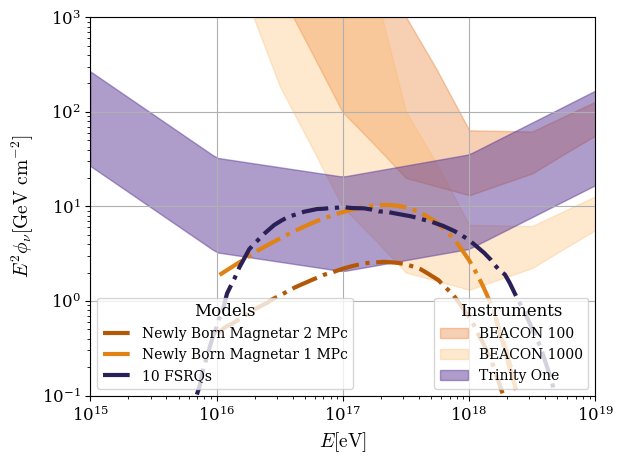

In [99]:
plt.fill_between(x_beacon, 10*y_beacon_min_i, 10*y_beacon_max_i, alpha=0.3, label='BEACON 100', color = '#E66101')
plt.fill_between(x_beacon, y_beacon_min_i, y_beacon_max_i, alpha=0.3, label='BEACON 1000', color = '#FDB863')
plt.fill_between(
    energy,
    neutrino_fluence_60_min,
    neutrino_fluence_60_max,
    color='#5E3C99',
    alpha=0.5,
    label='Trinity One'
)
plt.plot(magnetars_2[:,0],magnetars_2[:,1], lw = 3, color = '#B35806', ls = '-.', label = 'Newly Born Magnetar 2 MPc')
plt.plot(magnetars_1[:,0],magnetars_1[:,1], lw = 3, color = '#E08214', ls = '-.', label = 'Newly Born Magnetar 1 MPc')
plt.plot(fsrqs[:,0]*1e9,fsrqs[:,1], lw = 3, color = '#2A1F57', ls = '-.', label = '10 FSRQs')

plt.ylabel(r'$E^2 \phi_\nu [\rm{GeV\ cm}^{-2}]$')
plt.xlabel(r'$E [\rm{eV}]$')
plt.grid()
plt.ylim([1e-1, 1e3])
plt.xlim([1e15, 1e19])
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# Split into “main” (everything but the last 3) and “extra” (the last 3):
main_handles, main_labels   = handles[:-3], labels[:-3]
extra_handles, extra_labels = handles[-3:], labels[-3:]

# Create the first legend and add it manually:
leg1 = ax.legend(
    main_handles, main_labels,
    loc='lower right',         # or wherever you like
    fontsize='small',
    title='Instruments'
)
ax.add_artist(leg1)

# Then create the second legend for your last 3 curves:
ax.legend(
    extra_handles, extra_labels,
    loc='lower left',        # adjust as needed
    fontsize='small',
    title='Models'
)
plt.tight_layout()
plt.savefig('outputs/sensitivity_long.jpg', dpi=150)
plt.show()

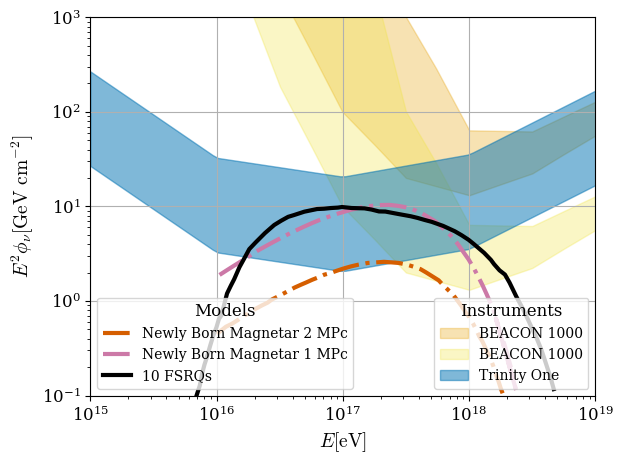

In [97]:
plt.fill_between(x_beacon, 10*y_beacon_min_i, 10*y_beacon_max_i,
    alpha=0.3, label='BEACON 1000', color='#E69F00')   # warm amber
plt.fill_between(x_beacon, y_beacon_min_i, y_beacon_max_i,
    alpha=0.3, label='BEACON 1000', color='#F0E442')   # golden yellow
plt.fill_between(
    energy,
    neutrino_fluence_60_min,
    neutrino_fluence_60_max,
    color='#0072B2',   # strong blue (Trinity emphasized)
    alpha=0.5,
    label='Trinity One'
)

plt.plot(magnetars_2[:,0],magnetars_2[:,1],
    lw=3, color='#D55E00', ls='-.', label='Newly Born Magnetar 2 MPc')   # dark orange
plt.plot(magnetars_1[:,0],magnetars_1[:,1],
    lw=3, color='#CC79A7', ls='-.', label='Newly Born Magnetar 1 MPc')   # magenta (contrasts both)
plt.plot(fsrqs[:,0]*1e9,fsrqs[:,1],
    lw=3, color='#000000', ls='-', label='10 FSRQs')   # solid black for max clarity

plt.ylabel(r'$E^2 \phi_\nu [\rm{GeV\ cm}^{-2}]$')
plt.xlabel(r'$E [\rm{eV}]$')
plt.grid()
plt.ylim([1e-1, 1e3])
plt.xlim([1e15, 1e19])
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# Split into “main” (everything but the last 3) and “extra” (the last 3):
main_handles, main_labels   = handles[:-3], labels[:-3]
extra_handles, extra_labels = handles[-3:], labels[-3:]

# Create the first legend and add it manually:
leg1 = ax.legend(
    main_handles, main_labels,
    loc='lower right',         # or wherever you like
    fontsize='small',
    title='Instruments'
)
ax.add_artist(leg1)

# Then create the second legend for your last 3 curves:
ax.legend(
    extra_handles, extra_labels,
    loc='lower left',        # adjust as needed
    fontsize='small',
    title='Models'
)
plt.tight_layout()
plt.savefig('outputs/sensitivity_long.jpg', dpi=150)
plt.show()

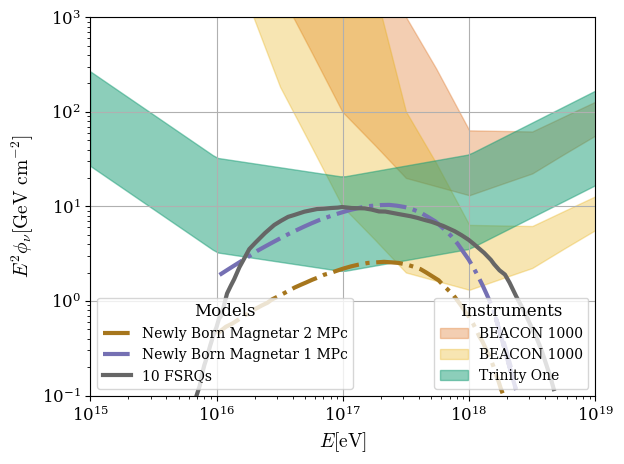

In [98]:
plt.fill_between(x_beacon, 10*y_beacon_min_i, 10*y_beacon_max_i,
    alpha=0.3, label='BEACON 1000', color='#D95F02')   # warm orange-red
plt.fill_between(x_beacon, y_beacon_min_i, y_beacon_max_i,
    alpha=0.3, label='BEACON 1000', color='#E6AB02')   # golden beige
plt.fill_between(
    energy,
    neutrino_fluence_60_min,
    neutrino_fluence_60_max,
    color='#1B9E77',   # teal green (Trinity emphasized)
    alpha=0.5,
    label='Trinity One'
)

plt.plot(magnetars_2[:,0],magnetars_2[:,1],
    lw=3, color='#A6761D', ls='-.', label='Newly Born Magnetar 2 MPc')   # dark ochre
plt.plot(magnetars_1[:,0],magnetars_1[:,1],
    lw=3, color='#7570B3', ls='-.', label='Newly Born Magnetar 1 MPc')   # indigo/violet
plt.plot(fsrqs[:,0]*1e9,fsrqs[:,1],
    lw=3, color='#666666', ls='-', label='10 FSRQs')   # neutral dark gray

plt.ylabel(r'$E^2 \phi_\nu [\rm{GeV\ cm}^{-2}]$')
plt.xlabel(r'$E [\rm{eV}]$')
plt.grid()
plt.ylim([1e-1, 1e3])
plt.xlim([1e15, 1e19])
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# Split into “main” (everything but the last 3) and “extra” (the last 3):
main_handles, main_labels   = handles[:-3], labels[:-3]
extra_handles, extra_labels = handles[-3:], labels[-3:]

# Create the first legend and add it manually:
leg1 = ax.legend(
    main_handles, main_labels,
    loc='lower right',         # or wherever you like
    fontsize='small',
    title='Instruments'
)
ax.add_artist(leg1)

# Then create the second legend for your last 3 curves:
ax.legend(
    extra_handles, extra_labels,
    loc='lower left',        # adjust as needed
    fontsize='small',
    title='Models'
)
plt.tight_layout()
plt.savefig('outputs/sensitivity_long.jpg', dpi=150)
plt.show()